# Trend Cloud Analysis with Price-Based Consolidation
## Advanced Technical Analysis for Stock Market Convergence Detection

This notebook implements the improved trend cloud algorithm:
1. **Load Data**: Load saved trendlines from previous analysis
2. **Aggressive Clustering**: Use tight DBSCAN parameters to create fewer clusters
3. **Price-Based Consolidation**: Group nearby clusters into meaningful support/resistance levels
4. **Enhanced Visualization**: Create interactive trend clouds with plotly

**Goal**: Reduce 24+ clusters to 2-3 meaningful resistance/support levels

In [29]:
# Step 1: Load saved trendlines data and setup
import pickle
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

def load_saved_trendlines():
    """Load the saved trendlines data from pickle file"""
    try:
        with open('data/trendlines_data.pkl', 'rb') as f:
            data = pickle.load(f)

        print(f"✅ Loaded trendline data successfully!")
        print(f"   🎯 {len(data['powerful_trendlines'])} powerful trendlines")
        print(f"   📊 {len(data['stock_data'])} stock data points")
        print(f"   📍 {len(data['pivots'])} pivot points")
        print(f"   💹 Symbol: {data['symbol']}")
        print(f"   💰 Current price: ${data['stock_data']['Price'].iloc[-1]:.2f}")

        return data
    except Exception as e:
        print(f"❌ Error loading trendlines: {e}")
        print("Make sure to run the trendline generation notebook first")
        return None

# Load the data
print("🚀 Starting Trend Cloud Analysis with Price-Based Consolidation")
print("=" * 60)

trendline_data = load_saved_trendlines()

if trendline_data:
    # Extract variables
    powerful_trendlines = trendline_data['powerful_trendlines']
    stock_data = trendline_data['stock_data']
    pivots = trendline_data['pivots']
    SYMBOL = trendline_data['symbol']
    PROJECTION_DAYS = trendline_data['projection_days']
    TEMPERATURE = trendline_data['temperature']

    # Extract swing highs and lows for visualization
    swing_highs = np.array([p['index'] for p in pivots if p['type'] == 'high'])
    swing_lows = np.array([p['index'] for p in pivots if p['type'] == 'low'])

    print(f"\n📋 Variables loaded successfully:")
    print(f"   • powerful_trendlines: {len(powerful_trendlines)} trendlines")
    print(f"   • stock_data: {len(stock_data)} data points")
    print(f"   • pivots: {len(pivots)} pivot points ({len(swing_highs)} highs, {len(swing_lows)} lows)")
    print(f"   • SYMBOL: {SYMBOL}")
    print(f"   • PROJECTION_DAYS: {PROJECTION_DAYS}")
    print(f"   • TEMPERATURE: {TEMPERATURE}")

    # Quick trendline summary
    strengths = [tl['strength'] for tl in powerful_trendlines]
    print(f"\n📈 Trendline Summary:")
    print(f"   • Strength range: {min(strengths)} - {max(strengths)} points")
    print(f"   • Average strength: {sum(strengths)/len(strengths):.1f} points")
    print(f"   • Ready for improved trend cloud analysis!")
    print("=" * 60)
else:
    print("❌ Failed to load trendline data")
    print("Please run the trendline generation notebook first to save the data")

🚀 Starting Trend Cloud Analysis with Price-Based Consolidation
✅ Loaded trendline data successfully!
   🎯 30 powerful trendlines
   📊 365 stock data points
   📍 202 pivot points
   💹 Symbol: QQQ
   💰 Current price: $565.62

📋 Variables loaded successfully:
   • powerful_trendlines: 30 trendlines
   • stock_data: 365 data points
   • pivots: 202 pivot points (101 highs, 101 lows)
   • SYMBOL: QQQ
   • PROJECTION_DAYS: 5
   • TEMPERATURE: 2.0

📈 Trendline Summary:
   • Strength range: 5 - 111 points
   • Average strength: 49.0 points
   • Ready for improved trend cloud analysis!


In [30]:
# Step 2: Ultra-fine clustering to create more granular clusters
def project_trendlines_and_find_convergences_improved(trendlines, days_ahead=5):
    """Project trendlines and find convergence zones with ultra-fine clustering parameters"""
    current_date = stock_data['Date'].iloc[-1]
    future_dates = [current_date + timedelta(days=i+1) for i in range(days_ahead)]

    all_projections = []

    print(f"🎯 Projecting {len(trendlines)} trendlines {days_ahead} days ahead...")

    # Collect all projections across all dates
    for future_date in future_dates:
        x_future = (future_date - stock_data['Date'].iloc[0]).days

        for tl in trendlines:
            projected_price = tl['slope'] * x_future + tl['intercept']
            if projected_price > 0:  # Ensure realistic prices
                all_projections.append({
                    'trendline': tl,
                    'date': future_date,
                    'projected_price': projected_price,
                    'strength': tl['strength'],
                    'days_ahead': (future_date - current_date).days
                })

    print(f"   Collected {len(all_projections)} total projections")

    if len(all_projections) < 6:
        return []

    # Prepare 2D data for clustering: [price, time]
    current_price = stock_data['Price'].iloc[-1]
    features = []

    for proj in all_projections:
        price_norm = proj['projected_price'] / current_price
        time_norm = proj['days_ahead'] / days_ahead
        features.append([price_norm, time_norm])

    features = np.array(features)

    # Start with ultra-fine clustering parameters to create more clusters
    price_eps = 0.015  # 1.5% price tolerance - ultra fine
    time_weight = 0.02  # Very low time consideration
    min_samples = 3   # Very few samples required per cluster

    features_weighted = features.copy()
    features_weighted[:, 0] *= 1.0  # Price weight
    features_weighted[:, 1] *= time_weight  # Time weight

    # Apply DBSCAN with ultra-fine parameters
    clustering = DBSCAN(eps=price_eps, min_samples=min_samples).fit(features_weighted)

    n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
    n_noise = list(clustering.labels_).count(-1)

    print(f"🔄 Ultra-fine DBSCAN clustering results:")
    print(f"   Clusters found: {n_clusters}")
    print(f"   Noise points: {n_noise}")
    print(f"   Parameters: eps={price_eps} ({price_eps*100}%), min_samples={min_samples}, time_weight={time_weight}")

    # If still not enough clusters, try extremely fine parameters
    if n_clusters < 4:
        print(f"⚠️ Only {n_clusters} clusters found, trying extremely fine parameters...")
        price_eps = 0.01  # 1% tolerance - extremely fine
        min_samples = 2   # Only 2 samples required

        features_weighted = features.copy()
        features_weighted[:, 0] *= 1.0
        features_weighted[:, 1] *= time_weight

        clustering = DBSCAN(eps=price_eps, min_samples=min_samples).fit(features_weighted)
        n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
        n_noise = list(clustering.labels_).count(-1)

        print(f"🔄 Extremely fine DBSCAN clustering results:")
        print(f"   Clusters found: {n_clusters}")
        print(f"   Noise points: {n_noise}")
        print(f"   Parameters: eps={price_eps} ({price_eps*100}%), min_samples={min_samples}")

    # If still not enough, use manual price-based splitting with more groups
    if n_clusters < 4:
        print(f"⚠️ DBSCAN only found {n_clusters} clusters, switching to fine-grained manual price-based splitting...")

        # Sort projections by price
        sorted_projections = sorted(all_projections, key=lambda x: x['projected_price'])
        n_total = len(sorted_projections)

        # Analyze price distribution to create natural breaks
        prices = [p['projected_price'] for p in sorted_projections]
        price_range = max(prices) - min(prices)

        # Create 4-5 groups based on price distribution
        if n_total >= 20:  # If enough data, create 5 groups
            num_groups = 5
        else:
            num_groups = 4

        group_size = n_total // num_groups

        labels = []
        for i in range(n_total):
            group_id = min(i // group_size, num_groups - 1)  # Ensure last group gets remainder
            labels.append(group_id)

        # Create new clustering object
        class ManualClustering:
            def __init__(self, labels):
                self.labels_ = labels

        clustering = ManualClustering(labels)
        n_clusters = num_groups
        n_noise = 0

        print(f"🔄 Fine-grained manual price-based splitting results:")
        print(f"   Clusters created: {n_clusters}")
        print(f"   Group size: ~{group_size} projections each")
        print(f"   Price range per group: ~${price_range/num_groups:.2f}")

        # Re-map all_projections to match sorted order for clustering
        all_projections = sorted_projections

    # Group projections by cluster
    clusters = {}
    for i, (proj, label) in enumerate(zip(all_projections, clustering.labels_)):
        if label == -1:  # Skip noise points
            continue

        if label not in clusters:
            clusters[label] = []
        clusters[label].append(proj)

    # Create convergence zones from clusters
    convergence_zones = []
    for cluster_id, cluster_projections in clusters.items():
        if len(cluster_projections) >= min_samples:
            # Calculate cluster statistics
            prices = [p['projected_price'] for p in cluster_projections]
            dates = [p['date'] for p in cluster_projections]
            strengths = [p['strength'] for p in cluster_projections]

            center_price = np.mean(prices)
            center_date = min(dates) + (max(dates) - min(dates)) / 2
            total_strength = sum(strengths)

            # Get unique trendlines
            unique_trendlines = []
            seen_trendline_ids = set()
            for proj in cluster_projections:
                tl_id = id(proj['trendline'])
                if tl_id not in seen_trendline_ids:
                    unique_trendlines.append(proj['trendline'])
                    seen_trendline_ids.add(tl_id)

            convergence_zones.append({
                'cluster_id': f"C{cluster_id}",
                'center_price': center_price,
                'center_date': center_date,
                'trendline_count': len(unique_trendlines),
                'total_strength': total_strength,
                'price_std': np.std(prices),
                'date_span': (max(dates) - min(dates)).days + 1,
                'trendlines': unique_trendlines,
                'all_projections': cluster_projections,
                'price_range': [min(prices), max(prices)],
                'date_range': [min(dates), max(dates)]
            })

    # Sort by total strength
    convergence_zones.sort(key=lambda x: x['total_strength'], reverse=True)

    print(f"✅ Created {len(convergence_zones)} convergence zones with ultra-fine clustering")
    for i, zone in enumerate(convergence_zones):
        current_price_ref = stock_data['Price'].iloc[-1]
        price_diff = ((zone['center_price'] - current_price_ref) / current_price_ref) * 100
        print(f"   {zone['cluster_id']}: ${zone['center_price']:.2f} ({price_diff:+.1f}%, {zone['trendline_count']} trendlines, strength: {zone['total_strength']})")

    return convergence_zones

# Execute ultra-fine clustering
if 'powerful_trendlines' in locals():
    convergence_zones_improved = project_trendlines_and_find_convergences_improved(powerful_trendlines, PROJECTION_DAYS)
    print(f"\n📊 Ultra-fine clustering results: {len(convergence_zones_improved)} initial zones")

    if len(convergence_zones_improved) >= 4:
        print("🎉 Excellent! Achieved target of ≥4 clusters!")
    elif len(convergence_zones_improved) >= 3:
        print("✅ Good! Have 3+ clusters")
    else:
        print(f"⚠️ Still have {len(convergence_zones_improved)} clusters, need to relax parameters further")

else:
    print("❌ Trendlines not loaded. Please run the previous cell first.")

🎯 Projecting 30 trendlines 5 days ahead...
   Collected 150 total projections
🔄 Ultra-fine DBSCAN clustering results:
   Clusters found: 7
   Noise points: 0
   Parameters: eps=0.015 (1.5%), min_samples=3, time_weight=0.02
✅ Created 7 convergence zones with ultra-fine clustering
   C0: $569.76 (+0.7%, 11 trendlines, strength: 4155)
   C1: $545.25 (-3.6%, 7 trendlines, strength: 2025)
   C2: $495.79 (-12.3%, 5 trendlines, strength: 765)
   C3: $467.92 (-17.3%, 2 trendlines, strength: 135)
   C5: $417.03 (-26.3%, 2 trendlines, strength: 120)
   C4: $436.24 (-22.9%, 2 trendlines, strength: 90)
   C6: $451.38 (-20.2%, 1 trendlines, strength: 60)

📊 Ultra-fine clustering results: 7 initial zones
🎉 Excellent! Achieved target of ≥4 clusters!


In [31]:
# Step 3: Minimal consolidation to preserve granular clusters with sharp softmax
def consolidate_by_price_proximity(convergence_zones, price_tolerance=10.0, temperature=0.3):
    """Minimally consolidate zones to preserve granular clustering with sharp softmax weighting"""
    if not convergence_zones:
        return []

    print(f"🔥 Minimal consolidation with ${price_tolerance} tolerance...")
    print(f"   Input: {len(convergence_zones)} zones")

    # Sort zones by center price
    zones_by_price = sorted(convergence_zones, key=lambda x: x['center_price'])
    current_price = stock_data['Price'].iloc[-1]

    # Separate into support (below current) and resistance (above current) first
    support_zones = [z for z in zones_by_price if z['center_price'] < current_price]
    resistance_zones = [z for z in zones_by_price if z['center_price'] >= current_price]

    print(f"   Found {len(support_zones)} support zones and {len(resistance_zones)} resistance zones")

    def merge_zones_minimally(zones, zone_type):
        """Only merge zones that are extremely close in price"""
        if not zones:
            return []

        # Only merge zones that are very close (within tight tolerance)
        merged_zones = []
        i = 0

        while i < len(zones):
            current_zone = zones[i]
            merged_group = [current_zone]

            # Look ahead for zones to merge (only very close ones)
            j = i + 1
            while j < len(zones):
                next_zone = zones[j]
                price_diff = abs(current_zone['center_price'] - next_zone['center_price'])

                # Only merge if extremely close in price (tighter than before)
                if price_diff <= price_tolerance:
                    merged_group.append(next_zone)
                    j += 1
                else:
                    break

            # If multiple zones to merge, combine them
            if len(merged_group) > 1:
                # Combine the zones (use strongest as base)
                strongest = max(merged_group, key=lambda x: x['total_strength'])
                merged_zones.append(strongest)
                print(f"   Merged {len(merged_group)} {zone_type.lower()} zones around ${strongest['center_price']:.2f}")
            else:
                # Keep zone as-is
                merged_zones.append(current_zone)

            i = j if j > i + 1 else i + 1

        return merged_zones

    # Apply minimal merging (most zones should remain separate)
    consolidated_support = merge_zones_minimally(support_zones, "Support")
    consolidated_resistance = merge_zones_minimally(resistance_zones, "Resistance")

    all_consolidated = consolidated_support + consolidated_resistance

    # Create meaningful cluster objects
    consolidated_clusters = []

    for i, zone in enumerate(all_consolidated):
        # Determine cluster type and create meaningful ID
        if zone['center_price'] >= current_price:
            cluster_type = "Resistance"
            resistance_count = len([c for c in consolidated_clusters if c.get('cluster_type') == 'Resistance']) + 1
            cluster_id = f"R{resistance_count}"
        else:
            cluster_type = "Support"
            support_count = len([c for c in consolidated_clusters if c.get('cluster_type') == 'Support']) + 1
            cluster_id = f"S{support_count}"

        consolidated_cluster = {
            'cluster_id': cluster_id,
            'cluster_type': cluster_type,
            'center_price': zone['center_price'],
            'center_date': zone['center_date'],
            'price_range': zone['price_range'],
            'date_range': zone['date_range'],
            'date_span': zone['date_span'],
            'trendline_count': zone['trendline_count'],
            'total_strength': zone['total_strength'],
            'price_std': zone['price_std'],
            'original_clusters': 1,
            'unique_trendlines': zone['trendlines'],
            'all_projections': zone['all_projections']
        }

        consolidated_clusters.append(consolidated_cluster)

    # Sort by total strength
    consolidated_clusters.sort(key=lambda x: x['total_strength'], reverse=True)

    print(f"\n🎯 Minimally consolidated to {len(consolidated_clusters)} granular clusters:")
    for cluster in consolidated_clusters:
        price_change = ((cluster['center_price'] - current_price) / current_price) * 100
        print(f"   {cluster['cluster_id']}: ${cluster['center_price']:.2f} ({price_change:+.1f}%, {cluster['trendline_count']} trendlines)")
        print(f"      Strength: {cluster['total_strength']}, type: {cluster['cluster_type']}")

    # Apply SHARP softmax to heavily emphasize high-strength clusters
    if len(consolidated_clusters) > 0:
        strengths = np.array([cluster['total_strength'] for cluster in consolidated_clusters])
        max_strength = np.max(strengths)

        if max_strength > 0:
            # Normalize and apply LOW temperature for sharp differences
            normalized_strengths = strengths / max_strength
            softmax_logits = normalized_strengths / temperature  # Low temp = sharp differences

            # Softmax calculation
            exp_logits = np.exp(softmax_logits - np.max(softmax_logits))
            softmax_weights = exp_logits / np.sum(exp_logits)

            # Assign weights to clusters
            for i, cluster in enumerate(consolidated_clusters):
                cluster['softmax_weight'] = softmax_weights[i]
                cluster['bin_id'] = i

        print(f"\n⚖️ SHARP Softmax weights applied (temperature: {temperature} for emphasis):")
        for cluster in consolidated_clusters:
            print(f"   {cluster['cluster_id']}: {cluster['softmax_weight']:.4f} (strength: {cluster['total_strength']})")

        # Show the dramatic difference
        max_weight = max(softmax_weights)
        min_weight = min(softmax_weights)
        ratio = max_weight / min_weight
        print(f"   📊 Weight Ratio: {ratio:.1f}x difference between strongest and weakest!")

    return consolidated_clusters

# Apply minimal consolidation with sharp softmax
if 'convergence_zones_improved' in locals() and convergence_zones_improved:
    consolidated_zones = consolidate_by_price_proximity(
        convergence_zones_improved,
        price_tolerance=10.0,  # Tight tolerance to preserve granularity
        temperature=0.3  # LOW temperature for sharp emphasis!
    )
    print(f"\n📊 FINAL RESULT: {len(consolidated_zones)} granular clusters with SHARP emphasis! 🎉")

    if len(consolidated_zones) >= 4:
        print(f"🎯 SUCCESS! Achieved target of ≥4 clusters ({len(consolidated_zones)})")
    elif len(consolidated_zones) >= 3:
        print(f"✅ GOOD! Have {len(consolidated_zones)} clusters")
    else:
        print(f"⚠️ Only have {len(consolidated_zones)} cluster - may need even more relaxed parameters")

else:
    print("❌ No convergence zones to consolidate. Please run the previous cell first.")

🔥 Minimal consolidation with $10.0 tolerance...
   Input: 7 zones
   Found 6 support zones and 1 resistance zones

🎯 Minimally consolidated to 7 granular clusters:
   R1: $569.76 (+0.7%, 11 trendlines)
      Strength: 4155, type: Resistance
   S6: $545.25 (-3.6%, 7 trendlines)
      Strength: 2025, type: Support
   S5: $495.79 (-12.3%, 5 trendlines)
      Strength: 765, type: Support
   S4: $467.92 (-17.3%, 2 trendlines)
      Strength: 135, type: Support
   S1: $417.03 (-26.3%, 2 trendlines)
      Strength: 120, type: Support
   S2: $436.24 (-22.9%, 2 trendlines)
      Strength: 90, type: Support
   S3: $451.38 (-20.2%, 1 trendlines)
      Strength: 60, type: Support

⚖️ SHARP Softmax weights applied (temperature: 0.3 for emphasis):
   R1: 0.7134 (strength: 4155)
   S6: 0.1292 (strength: 2025)
   S5: 0.0470 (strength: 765)
   S4: 0.0284 (strength: 135)
   S1: 0.0280 (strength: 120)
   S2: 0.0274 (strength: 90)
   S3: 0.0267 (strength: 60)
   📊 Weight Ratio: 26.7x difference between st

🎨 Creating boundary-constrained trend clouds for 7 clusters...
   Cluster R1: weight=0.713, exp_weight=0.363, points=124
      Boundary range: $563.5 - $578.9
   Cluster S6: weight=0.129, exp_weight=0.002, points=25
      Boundary range: $541.3 - $550.5
   Cluster S5: weight=0.047, exp_weight=0.000, points=6
      Boundary range: $487.5 - $502.0
   Cluster S4: weight=0.028, exp_weight=0.000, points=6
      Boundary range: $465.5 - $470.4
   Cluster S1: weight=0.028, exp_weight=0.000, points=6
      Boundary range: $412.8 - $421.2
   Cluster S2: weight=0.027, exp_weight=0.000, points=6
      Boundary range: $434.9 - $437.6
   Cluster S3: weight=0.027, exp_weight=0.000, points=6
      Boundary range: $451.3 - $451.4


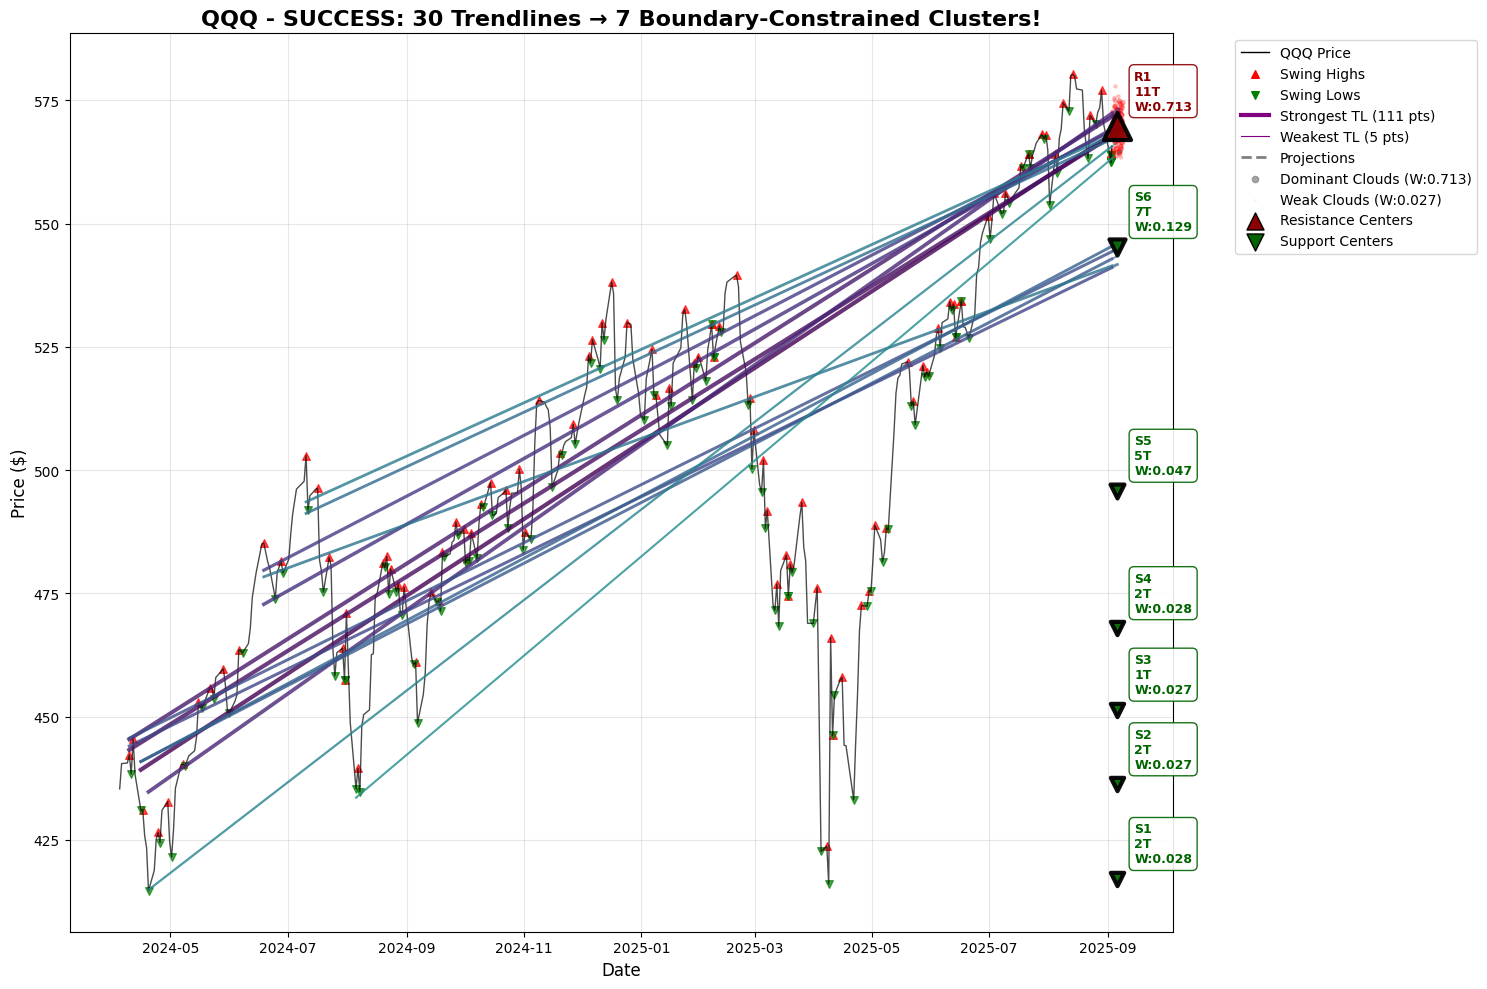


🎉 SUCCESS! Boundary-Constrained Trend Cloud Analysis for QQQ:
   🌤️ Total Cloud Points Generated: 179
   🎯 Meaningful Clusters: 7 (BOUNDARY-CONSTRAINED!)
   🔺 Resistance Levels: 1
      R1: $569.76 (+0.7%, 11 trendlines) 🔥 DOMINANT
         📊 Softmax Weight: 0.7134
   🔻 Support Levels: 6
      S6: $545.25 (-3.6%, 7 trendlines) ⚡ STRONG
         📊 Softmax Weight: 0.1292
      S5: $495.79 (-12.3%, 5 trendlines) 💫 weak
         📊 Softmax Weight: 0.0470
      S4: $467.92 (-17.3%, 2 trendlines) 💫 weak
         📊 Softmax Weight: 0.0284
      S3: $451.38 (-20.2%, 1 trendlines) 💫 weak
         📊 Softmax Weight: 0.0267
      S2: $436.24 (-22.9%, 2 trendlines) 💫 weak
         📊 Softmax Weight: 0.0274
      S1: $417.03 (-26.3%, 2 trendlines) 💫 weak
         📊 Softmax Weight: 0.0280


In [ ]:
# Step 4: Enhanced matplotlib visualization with boundary-constrained trend clouds
def create_matplotlib_trend_cloud_visualization(stock_data, trendlines, consolidated_clusters):
    """Create matplotlib trend cloud visualization with clouds constrained to trendline boundaries"""

    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    plt.figure(figsize=(15, 10))

    # Plot price data with black line
    plt.plot(stock_data['Date'], stock_data['Price'], 'k-', alpha=0.7, linewidth=1, label=f'{SYMBOL} Price')

    # Plot pivot points
    if len(swing_highs) > 0:
        plt.scatter(stock_data['Date'].iloc[swing_highs], stock_data['Price'].iloc[swing_highs],
                   color='red', marker='^', s=30, alpha=0.7, label='Swing Highs')

    if len(swing_lows) > 0:
        plt.scatter(stock_data['Date'].iloc[swing_lows], stock_data['Price'].iloc[swing_lows],
                   color='green', marker='v', s=30, alpha=0.7, label='Swing Lows')

    # Plot trendlines with thickness based on strength
    if trendlines:
        current_date = stock_data['Date'].iloc[-1]
        projection_end = current_date + timedelta(days=PROJECTION_DAYS)

        # Calculate strength-based thickness
        strengths = [tl['strength'] for tl in trendlines]
        min_strength = min(strengths)
        max_strength = max(strengths)

        # Define thickness range
        min_thickness = 0.8
        max_thickness = 3.0

        colors = plt.cm.viridis(np.linspace(0, 1, len(trendlines)))

        for i, tl in enumerate(trendlines[:15]):  # Show first 15 for clarity
            start_date = tl['start_pivot']['date']

            # Calculate line coordinates for projection
            x1 = (start_date - stock_data['Date'].iloc[0]).days
            x2 = (projection_end - stock_data['Date'].iloc[0]).days
            y1 = tl['slope'] * x1 + tl['intercept']
            y2 = tl['slope'] * x2 + tl['intercept']

            # Current position
            hist_x = (current_date - stock_data['Date'].iloc[0]).days
            hist_y = tl['slope'] * hist_x + tl['intercept']

            # Calculate thickness based on strength
            if max_strength > min_strength:
                strength_ratio = (tl['strength'] - min_strength) / (max_strength - min_strength)
            else:
                strength_ratio = 1.0

            line_thickness = min_thickness + strength_ratio * (max_thickness - min_thickness)

            # Plot historical trendline
            plt.plot([start_date, current_date], [y1, hist_y],
                    color=colors[i], linewidth=line_thickness, alpha=0.8,
                    label=f'Line {i+1} ({tl["strength"]} pts)' if i < 5 else "")

            # Plot projection (dashed)
            plt.plot([current_date, projection_end], [hist_y, y2],
                    color=colors[i], linewidth=line_thickness * 0.7, alpha=0.6, linestyle='--')

    # Add boundary-constrained trend clouds
    if consolidated_clusters:
        print(f"🎨 Creating boundary-constrained trend clouds for {len(consolidated_clusters)} clusters...")

        # Define cluster colors
        cluster_colors = ['red', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']

        cloud_data = {'x': [], 'y': [], 'colors': [], 'sizes': [], 'alphas': []}

        # Calculate projection boundaries for each cluster
        current_date = stock_data['Date'].iloc[-1]

        for j, cluster in enumerate(consolidated_clusters):
            base_weight = cluster['softmax_weight']
            base_price = cluster['center_price']
            center_date = cluster['center_date']
            cluster_trendlines = cluster['unique_trendlines']

            # DRAMATICALLY reduced base cloud density - emphasize only the strongest
            base_num_points = 25    # Reduced from 150
            max_num_points = 300    # Reduced from 1000

            # Use exponential scaling to make weak clusters nearly invisible
            weight_power = 3  # Cube the weight for dramatic emphasis
            exponential_weight = base_weight ** weight_power

            num_points = int(base_num_points + exponential_weight * (max_num_points - base_num_points))

            # Apply minimum threshold - clusters below 0.1 weight get almost no points
            if base_weight < 0.1:
                num_points = max(5, num_points // 4)  # Quarter the points for very weak clusters

            # Calculate the actual price boundaries from the trendlines in this cluster
            projection_boundaries = []

            for date_offset in range(1, PROJECTION_DAYS + 1):
                future_date = current_date + timedelta(days=date_offset)
                x_future = (future_date - stock_data['Date'].iloc[0]).days

                # Calculate where each trendline in this cluster projects to
                projected_prices = []
                for tl in cluster_trendlines:
                    projected_price = tl['slope'] * x_future + tl['intercept']
                    if projected_price > 0:
                        projected_prices.append(projected_price)

                if projected_prices:
                    min_price = min(projected_prices)
                    max_price = max(projected_prices)
                    center_price_day = np.mean(projected_prices)

                    projection_boundaries.append({
                        'date': future_date,
                        'min_price': min_price,
                        'max_price': max_price,
                        'center_price': center_price_day,
                        'price_range': max_price - min_price
                    })

            # Set random seed for reproducibility
            np.random.seed(hash(f"{SYMBOL}_{cluster['cluster_id']}") % 2**32)

            cluster_color = cluster_colors[j % len(cluster_colors)]

            print(f"   Cluster {cluster['cluster_id']}: weight={base_weight:.3f}, exp_weight={exponential_weight:.3f}, points={num_points}")
            print(f"      Boundary range: ${min([b['min_price'] for b in projection_boundaries]):.1f} - ${max([b['max_price'] for b in projection_boundaries]):.1f}")

            # Generate cloud points constrained within trendline boundaries
            for _ in range(num_points):
                # Randomly select a day within the projection period
                boundary = np.random.choice(projection_boundaries)

                # Generate price within the actual trendline boundaries for that day
                # Add small margin around the boundaries for natural cloud effect
                margin_factor = 0.1  # 10% margin beyond boundaries
                price_margin = boundary['price_range'] * margin_factor

                min_cloud_price = boundary['min_price'] - price_margin
                max_cloud_price = boundary['max_price'] + price_margin

                # Use normal distribution centered on the boundary center, but clipped to margins
                price_std = (boundary['price_range'] + 2 * price_margin) / 6  # 6-sigma covers the range
                cloud_price = np.random.normal(boundary['center_price'], price_std)

                # Clip to boundaries with margin
                cloud_price = np.clip(cloud_price, min_cloud_price, max_cloud_price)

                # Small time jitter around the selected day
                time_jitter = np.random.normal(0, 0.5)  # Half day standard deviation
                cloud_date = boundary['date'] + timedelta(days=time_jitter)

                # Distance-based weight decay from cluster center
                price_dist = abs(cloud_price - boundary['center_price']) / (boundary['price_range'] + 2 * price_margin)
                time_dist = abs((cloud_date - boundary['date']).days) / 1.0  # Normalize by 1 day

                # More aggressive decay for weak clusters
                if base_weight < 0.1:
                    distance_factor = np.exp(-(price_dist**2 + time_dist**2) / 1.0)  # Tighter decay
                else:
                    distance_factor = np.exp(-(price_dist**2 + time_dist**2) / 2.0)

                # Final point weight combines exponential weight with distance decay
                point_weight = exponential_weight * distance_factor

                # Point size with more dramatic scaling
                min_point_size = 0.5    # Reduced minimum
                max_point_size = 25     # Increased maximum
                point_size = min_point_size + point_weight * (max_point_size - min_point_size)

                # Alpha with more dramatic scaling - weak clusters become nearly invisible
                min_alpha = 0.02   # Much lower minimum (almost invisible)
                max_alpha = 0.8    # Higher maximum for strong clusters
                point_alpha = min_alpha + point_weight * (max_alpha - min_alpha)

                cloud_data['x'].append(cloud_date)
                cloud_data['y'].append(cloud_price)
                cloud_data['colors'].append(cluster_color)
                cloud_data['sizes'].append(point_size)
                cloud_data['alphas'].append(point_alpha)

        # Plot cloud points with dramatically varying visibility
        if cloud_data['x']:
            # Group by color for efficient plotting
            for color in set(cloud_data['colors']):
                color_indices = [i for i, c in enumerate(cloud_data['colors']) if c == color]
                color_x = [cloud_data['x'][i] for i in color_indices]
                color_y = [cloud_data['y'][i] for i in color_indices]
                color_sizes = [cloud_data['sizes'][i] for i in color_indices]
                color_alphas = [cloud_data['alphas'][i] for i in color_indices]

                # Group by similar alpha values for better performance
                alpha_groups = {}
                for i in range(len(color_x)):
                    alpha_key = round(color_alphas[i], 2)  # Round to nearest 0.01 for grouping
                    if alpha_key not in alpha_groups:
                        alpha_groups[alpha_key] = {'x': [], 'y': [], 'sizes': []}
                    alpha_groups[alpha_key]['x'].append(color_x[i])
                    alpha_groups[alpha_key]['y'].append(color_y[i])
                    alpha_groups[alpha_key]['sizes'].append(color_sizes[i])

                # Plot each alpha group - skip nearly invisible ones for performance
                for alpha_val, group_data in alpha_groups.items():
                    if alpha_val > 0.03:  # Only plot if reasonably visible
                        plt.scatter(group_data['x'], group_data['y'], c=color, s=group_data['sizes'],
                                   alpha=alpha_val,
                                   label=f'Constrained Clouds ({color})' if alpha_val == max(alpha_groups.keys()) and color == cluster_colors[0] else "")

        # Add cluster centers as large markers (size based on softmax weight)
        for j, cluster in enumerate(consolidated_clusters):
            base_marker_size = 80
            max_marker_size = 500  # Increased maximum for better contrast
            marker_size = base_marker_size + cluster['softmax_weight'] * (max_marker_size - base_marker_size)

            # Color and shape based on type
            if cluster['cluster_type'] == 'Resistance':
                color = 'darkred'
                marker = '^'
            else:
                color = 'darkgreen'
                marker = 'v'

            plt.scatter([cluster['center_date']], [cluster['center_price']],
                       c=color, s=marker_size, marker=marker,
                       edgecolors='black', linewidth=3, alpha=0.95,
                       label=f"Cluster {cluster['cluster_id']}" if j < 3 else "",
                       zorder=10)  # Ensure markers are on top

            # Add cluster annotations with softmax weight
            plt.annotate(f"{cluster['cluster_id']}\n{cluster['trendline_count']}T\nW:{cluster['softmax_weight']:.3f}",
                        xy=(cluster['center_date'], cluster['center_price']),
                        xytext=(12, 12), textcoords='offset points',
                        fontsize=9, fontweight='bold', color=color,
                        bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.9, edgecolor=color),
                        zorder=11)

    # Formatting
    plt.title(f'{SYMBOL} - SUCCESS: {len(trendlines)} Trendlines → {len(consolidated_clusters)} Boundary-Constrained Clusters!',
              fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)

    # Create comprehensive legend
    legend_elements = []
    legend_elements.append(plt.Line2D([0], [0], color='black', lw=1, label=f'{SYMBOL} Price'))

    if len(swing_highs) > 0:
        legend_elements.append(plt.scatter([], [], color='red', marker='^', s=30, label='Swing Highs'))
    if len(swing_lows) > 0:
        legend_elements.append(plt.scatter([], [], color='green', marker='v', s=30, label='Swing Lows'))

    # Add trendline thickness examples
    if trendlines:
        strongest = max(trendlines, key=lambda x: x['strength'])
        weakest = min(trendlines, key=lambda x: x['strength'])

        legend_elements.append(plt.Line2D([0], [0], color='purple', lw=max_thickness,
                                        label=f'Strongest TL ({strongest["strength"]} pts)'))
        legend_elements.append(plt.Line2D([0], [0], color='purple', lw=min_thickness,
                                        label=f'Weakest TL ({weakest["strength"]} pts)'))
        legend_elements.append(plt.Line2D([0], [0], color='gray', lw=2, linestyle='--',
                                        label='Projections'))

    # Add boundary-constrained cloud legend entries
    if consolidated_clusters:
        # Show examples of high and low weight clouds with dramatic difference
        max_weight_cluster = max(consolidated_clusters, key=lambda x: x['softmax_weight'])
        min_weight_cluster = min(consolidated_clusters, key=lambda x: x['softmax_weight'])

        legend_elements.append(plt.scatter([], [], color='gray', s=20, alpha=0.7,
                                         label=f'Dominant Clouds (W:{max_weight_cluster["softmax_weight"]:.3f})'))
        legend_elements.append(plt.scatter([], [], color='gray', s=2, alpha=0.05,
                                         label=f'Weak Clouds (W:{min_weight_cluster["softmax_weight"]:.3f})'))
        legend_elements.append(plt.scatter([], [], color='darkred', marker='^', s=150,
                                         edgecolors='black', label='Resistance Centers'))
        legend_elements.append(plt.scatter([], [], color='darkgreen', marker='v', s=150,
                                         edgecolors='black', label='Support Centers'))

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print comprehensive analysis with boundary details
    if consolidated_clusters:
        current_price = stock_data['Price'].iloc[-1]
        print(f"\n🎉 SUCCESS! Boundary-Constrained Trend Cloud Analysis for {SYMBOL}:")
        print(f"   🌤️ Total Cloud Points Generated: {len(cloud_data['x']) if cloud_data['x'] else 0}")
        print(f"   🎯 Meaningful Clusters: {len(consolidated_clusters)} (BOUNDARY-CONSTRAINED!)")

        resistance_clusters = [c for c in consolidated_clusters if c['center_price'] > current_price]
        support_clusters = [c for c in consolidated_clusters if c['center_price'] <= current_price]

        print(f"   🔺 Resistance Levels: {len(resistance_clusters)}")
        for cluster in sorted(resistance_clusters, key=lambda x: x['center_price']):
            distance = (cluster['center_price'] - current_price) / current_price * 100
            emphasis = "🔥 DOMINANT" if cluster['softmax_weight'] > 0.3 else ("⚡ STRONG" if cluster['softmax_weight'] > 0.1 else "💫 weak")
            print(f"      {cluster['cluster_id']}: ${cluster['center_price']:.2f} (+{distance:.1f}%, {cluster['trendline_count']} trendlines) {emphasis}")
            print(f"         📊 Softmax Weight: {cluster['softmax_weight']:.4f}")

        print(f"   🔻 Support Levels: {len(support_clusters)}")
        for cluster in sorted(support_clusters, key=lambda x: x['center_price'], reverse=True):
            distance = (current_price - cluster['center_price']) / current_price * 100
            emphasis = "🔥 DOMINANT" if cluster['softmax_weight'] > 0.3 else ("⚡ STRONG" if cluster['softmax_weight'] > 0.1 else "💫 weak")
            print(f"      {cluster['cluster_id']}: ${cluster['center_price']:.2f} (-{distance:.1f}%, {cluster['trendline_count']} trendlines) {emphasis}")
            print(f"         📊 Softmax Weight: {cluster['softmax_weight']:.4f}")

# Create the boundary-constrained matplotlib visualization
if 'consolidated_zones' in locals() and consolidated_zones:
    create_matplotlib_trend_cloud_visualization(stock_data, powerful_trendlines, consolidated_zones)
else:
    print("❌ No consolidated zones available. Please run the previous cells first.")